* importing library 

In [124]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

* loading and understanding data

In [125]:
shared_articles_df = pd.read_csv(r'C:\Projects\recommender-systems\Dataset\shared_articles.csv')

In [126]:
shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [127]:
shared_articles_df.shape

(3122, 13)

In [128]:
shared_articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        3122 non-null   int64 
 1   eventType        3122 non-null   object
 2   contentId        3122 non-null   int64 
 3   authorPersonId   3122 non-null   int64 
 4   authorSessionId  3122 non-null   int64 
 5   authorUserAgent  680 non-null    object
 6   authorRegion     680 non-null    object
 7   authorCountry    680 non-null    object
 8   contentType      3122 non-null   object
 9   url              3122 non-null   object
 10  title            3122 non-null   object
 11  text             3122 non-null   object
 12  lang             3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [129]:
shared_articles_df.isnull().sum()

timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64

* dropping of unrelated and unnecessary items

In [130]:
drop_list = ['authorUserAgent', 'authorRegion', 'authorCountry']
drop_list = [col for col in drop_list if col in shared_articles_df.columns]
shared_articles_df.drop(drop_list,axis=1,inplace=True)

In [131]:
shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


* There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.


eventType
CONTENT SHARED     3047
CONTENT REMOVED      75
Name: count, dtype: int64


<Axes: xlabel='eventType', ylabel='count'>

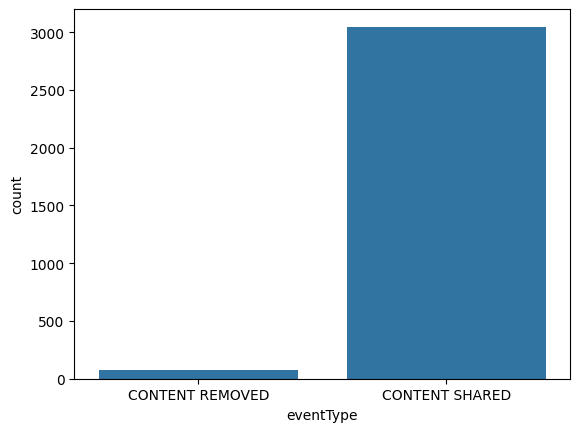

In [132]:
print(shared_articles_df['eventType'].value_counts())
sns.countplot(x=shared_articles_df['eventType'],data=shared_articles_df)

In [133]:
shared_articles_df = shared_articles_df[shared_articles_df['eventType'] == 'CONTENT SHARED']
shared_articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [134]:
user_interaction_df = pd.read_csv(r'C:\Projects\recommender-systems\Dataset\users_interactions.csv')
user_interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [135]:
user_interaction_df.shape

(72312, 8)

In [136]:
user_interaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    72312 non-null  int64 
 1   eventType    72312 non-null  object
 2   contentId    72312 non-null  int64 
 3   personId     72312 non-null  int64 
 4   sessionId    72312 non-null  int64 
 5   userAgent    56918 non-null  object
 6   userRegion   56907 non-null  object
 7   userCountry  56918 non-null  object
dtypes: int64(4), object(4)
memory usage: 4.4+ MB


In [137]:
user_interaction_df.isnull().sum()

timestamp          0
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
dtype: int64

In [138]:
user_interaction_df.dropna(inplace=True)

In [139]:
user_interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
12,1465415228,VIEW,3460026829794173084,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR
13,1465415691,VIEW,7763750328910542816,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR


eventType
VIEW               54431
LIKE                1256
BOOKMARK             479
FOLLOW               403
COMMENT CREATED      338
Name: count, dtype: int64


<Axes: xlabel='eventType', ylabel='count'>

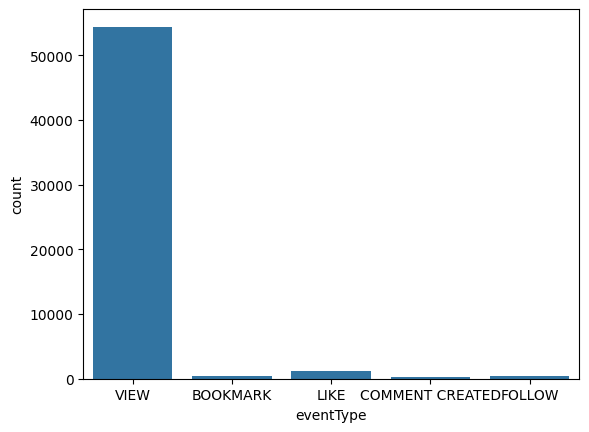

In [140]:
print(user_interaction_df['eventType'].value_counts())
sns.countplot(x=user_interaction_df['eventType'],data=user_interaction_df)

* As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [141]:
event_type_dict = {
    'VIEW' : 1.0 ,
    'LIKE' : 2.0 ,
    'BOOKMARK' : 3.0 , 
    'FOLLOW' : 4.0 ,
    'COMMENT CREATED' : 5.0
}

user_interaction_df['new_event_type'] = user_interaction_df['eventType'].map(event_type_dict)

In [142]:
user_interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1.0
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
12,1465415228,VIEW,3460026829794173084,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR,1.0
13,1465415691,VIEW,7763750328910542816,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR,1.0


In [143]:
user_interaction_df.groupby(['personId', 'contentId']).size()

personId              contentId           
-9223121837663643404  -8949113594875411859    1
                      -8377626164558006982    1
                      -8208801367848627943    1
                      -8187220755213888616    1
                      -7423191370472335463    8
                                             ..
 9210530975708218054   8477804012624580461    4
                       8526042588044002101    1
                       8856169137131817223    1
                       8869347744613364434    1
                       9209886322932807692    1
Length: 40307, dtype: int64

In [144]:
user_interaction_df[(user_interaction_df['personId']==-9223121837663643404) & (user_interaction_df['contentId']==-7423191370472335463)].sort_values(by=['timestamp'])

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
60988,1478687166,VIEW,-7423191370472335463,-9223121837663643404,2411828781515959462,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
64003,1478705793,VIEW,-7423191370472335463,-9223121837663643404,2411828781515959462,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
61256,1478795892,VIEW,-7423191370472335463,-9223121837663643404,-4096620279830729916,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63155,1478860184,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63183,1478860897,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63180,1478862151,VIEW,-7423191370472335463,-9223121837663643404,844431470588928965,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
65167,1479290925,VIEW,-7423191370472335463,-9223121837663643404,-8865295409778928525,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
63834,1479376578,VIEW,-7423191370472335463,-9223121837663643404,-6084152871682607649,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0


In [145]:
user_interaction_df[(user_interaction_df['personId']==9210530975708218054) & (user_interaction_df['contentId']==8477804012624580461)].sort_values(by=['timestamp'])

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,new_event_type
68300,1486577685,VIEW,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
68290,1486577725,BOOKMARK,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,3.0
68291,1486577726,LIKE,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,2.0
68297,1486577729,FOLLOW,8477804012624580461,9210530975708218054,3436065331471531836,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,4.0


* Recommender systems have a problem known as ***user cold-start***, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [146]:
# Calculates the number of users based on the number of content they have interacted with
users_interactions_count_df = user_interaction_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))

# users: 1895


In [147]:
# The code counts and displays the number of users who have had five or more interactions with the content.
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1139


In [148]:
print('# of interactions: %d' % len(user_interaction_df))

# of interactions: 56907


In [149]:
# Counts the number of interactions made by users who have five or more interactions with the content.
interactions_from_selected_users_df = user_interaction_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 54864


In [188]:
interactions_from_selected_users_df.groupby(['eventType','new_event_type']).size()

eventType        new_event_type
BOOKMARK         3.0                 469
COMMENT CREATED  5.0                 330
FOLLOW           4.0                 395
LIKE             2.0                1222
VIEW             1.0               52448
dtype: int64

In [150]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['new_event_type'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 38702


,personId,contentId,new_event_type
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.000000


* Evaluation 

In [151]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 30961
# interactions on Test set: 7741


In [152]:
# Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [153]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [154]:
#  Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def __init__(self, interactions_test_indexed_df):
        self.interactions_test_indexed_df = interactions_test_indexed_df

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(shared_articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        # Convert set to list before sampling
        non_interacted_items_list = list(non_interacted_items)
    
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items_list, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator(interactions_test_indexed_df)    

In [155]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['new_event_type'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,new_event_type
0,-4029704725707465084,310.791362
1,-133139342397538859,198.642314
2,-6783772548752091658,186.343106
3,1469580151036142903,172.066596
4,-8208801367848627943,160.387500
5,-6843047699859121724,158.906977
6,7507067965574797372,156.080072
7,2581138407738454418,152.243571
8,-4333957157636611418,150.120591
9,-2358756719610361882,142.830444


In [156]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('new_event_type', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['new_event_type', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, shared_articles_df)

In [157]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1138 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.24609223614520087, 'recall@10': 0.3754036946130991}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
67,27,51,192,0.140625,0.265625,3609194402293569455
16,14,25,134,0.104478,0.186567,-2626634673110551643
3,7,18,128,0.054688,0.140625,-1032019229384696495
26,8,16,117,0.068376,0.136752,-1443636648652872475
47,24,41,88,0.272727,0.465909,-2979881261169775358
25,9,10,80,0.112500,0.125000,-3596626804281480007
87,12,18,69,0.173913,0.260870,692689608292948411
196,12,21,69,0.173913,0.304348,-9016528795238256703
5,18,26,69,0.260870,0.376812,1116121227607581999
109,17,22,68,0.250000,0.323529,3636910968448833585


In [158]:
shared_articles_df['lang'].value_counts()

lang
en    2211
pt     829
la       3
es       2
ja       2
Name: count, dtype: int64

* Content-Based Filtering model

In [159]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = shared_articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(shared_articles_df['title'] + "" + shared_articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638118 stored elements in Compressed Sparse Row format>

In [160]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['new_event_type']).reshape(-1, 1)
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    
    # Convert to numpy array before normalization
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg)
    
    # Normalize the user profile
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(shared_articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [161]:
user_profiles = build_users_profiles()
len(user_profiles)

1139

In [162]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.327283
1,machine learning,0.259397
2,machine,0.249657
3,google,0.213022
4,data,0.177261
5,graph,0.129505
6,ai,0.118555
7,algorithms,0.117101
8,like,0.095851
9,deep learning,0.089913


In [163]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(shared_articles_df)

In [164]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1138 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16987469319209406, 'recall@10': 0.26521121302157347}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
67,13,26,192,0.067708,0.135417,3609194402293569455
16,16,27,134,0.119403,0.201493,-2626634673110551643
3,13,26,128,0.101562,0.203125,-1032019229384696495
26,26,48,117,0.222222,0.410256,-1443636648652872475
47,12,20,88,0.136364,0.227273,-2979881261169775358
25,10,21,80,0.125000,0.262500,-3596626804281480007
87,12,19,69,0.173913,0.275362,692689608292948411
196,5,11,69,0.072464,0.159420,-9016528795238256703
5,6,12,69,0.086957,0.173913,1116121227607581999
109,6,10,68,0.088235,0.147059,3636910968448833585


* Collaborative Filtering model
- Matrix Factorization

In [165]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='new_event_type').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
print(users_items_pivot_matrix[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [167]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [168]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1139x2924 sparse matrix of type '<class 'numpy.float64'>'
	with 30961 stored elements in Compressed Sparse Row format>

In [169]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [170]:
U.shape

(1139, 15)

In [171]:
Vt.shape

(15, 2924)

In [172]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [173]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 4.45108083e-02,  4.09911540e-03,  2.41854078e-02, ...,
        -1.80979055e-02, -1.31977435e-02,  2.14849467e-03],
       [-3.11404098e-04,  2.49646228e-04, -5.75730783e-04, ...,
         9.32248357e-04, -1.49168870e-03,  5.07885174e-05],
       [-2.76411264e-02,  2.47261279e-02, -2.68315726e-02, ...,
        -3.63567884e-02, -3.63013173e-02,  2.52896654e-03],
       ...,
       [-1.53843357e-02,  2.15224296e-02, -2.77460824e-02, ...,
        -3.09065187e-02, -2.72525644e-02,  2.56473907e-03],
       [ 5.06041331e-03,  1.52745592e-02, -5.95606237e-03, ...,
        -1.57906499e-02, -7.70065763e-03, -3.78155652e-03],
       [ 3.19473129e-04,  2.94494750e-03,  8.63721086e-02, ...,
        -1.09827293e-01, -7.59392663e-02, -4.49280243e-03]])

In [174]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [175]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.254800,0.248668,0.244928,0.251894,0.248506,0.248409,0.250219,0.250643,0.244821,0.253551,...,0.253198,0.239874,0.248340,0.248562,0.246068,0.248410,0.249588,0.246605,0.249403,0.248754
-9216926795620865886,0.249271,0.248744,0.252093,0.248638,0.248623,0.248711,0.248762,0.248954,0.248530,0.249034,...,0.248879,0.251918,0.248641,0.248888,0.248501,0.248740,0.248991,0.251655,0.250800,0.249113
-9194572880052200111,0.252019,0.248631,0.245039,0.248115,0.249954,0.248643,0.249573,0.248913,0.247911,0.247474,...,0.248535,0.273212,0.248653,0.247626,0.262105,0.250645,0.249329,0.244914,0.247895,0.260528
-9192549002213406534,0.252483,0.248626,0.243144,0.247758,0.249516,0.249414,0.251028,0.251727,0.249695,0.249329,...,0.251534,0.254814,0.249655,0.249247,0.249857,0.249858,0.250627,0.243828,0.250325,0.244474
-9190737901804729417,0.250049,0.248676,0.247867,0.249493,0.248771,0.248682,0.249003,0.248681,0.248239,0.249902,...,0.249503,0.248567,0.248703,0.248595,0.248426,0.248683,0.248813,0.248284,0.248893,0.248663
-9189659052158407108,0.252621,0.248815,0.252045,0.247994,0.249333,0.248663,0.250284,0.248998,0.250904,0.248083,...,0.250085,0.271709,0.248758,0.248869,0.257646,0.249843,0.250040,0.251680,0.252931,0.262158
-9184137057748005562,0.248706,0.248688,0.249332,0.248744,0.248688,0.248755,0.248783,0.248711,0.248781,0.249299,...,0.248943,0.249084,0.248670,0.248624,0.248622,0.248735,0.248836,0.249327,0.249274,0.247260
-9176143510534135851,0.256993,0.249031,0.254224,0.250588,0.248241,0.247927,0.250493,0.252515,0.248654,0.252207,...,0.251608,0.267834,0.248005,0.247963,0.246848,0.248081,0.249412,0.254251,0.255528,0.262640
-9172673334835262304,0.248201,0.248669,0.248227,0.248661,0.248695,0.248813,0.248760,0.248658,0.248762,0.248835,...,0.249012,0.247093,0.248829,0.248654,0.248861,0.248638,0.248963,0.248359,0.248873,0.243990


In [176]:
len(cf_preds_df.columns)

1139

In [177]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, shared_articles_df)

In [178]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1138 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3363906472032037, 'recall@10': 0.4637643715282263}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
67,44,62,192,0.229167,0.322917,3609194402293569455
16,34,51,134,0.253731,0.380597,-2626634673110551643
3,17,32,128,0.132812,0.250000,-1032019229384696495
26,23,38,117,0.196581,0.324786,-1443636648652872475
47,28,37,88,0.318182,0.420455,-2979881261169775358
25,23,33,80,0.287500,0.412500,-3596626804281480007
87,15,21,69,0.217391,0.304348,692689608292948411
196,19,24,69,0.275362,0.347826,-9016528795238256703
5,20,35,69,0.289855,0.507246,1116121227607581999
109,11,19,68,0.161765,0.279412,3636910968448833585


* Hybrid Recommender

In [179]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, shared_articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [180]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1138 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.34917969254618264, 'recall@10': 0.47926624467123113}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
67,48,60,192,0.250000,0.312500,3609194402293569455
16,36,53,134,0.268657,0.395522,-2626634673110551643
3,18,31,128,0.140625,0.242188,-1032019229384696495
26,24,39,117,0.205128,0.333333,-1443636648652872475
47,29,37,88,0.329545,0.420455,-2979881261169775358
25,24,36,80,0.300000,0.450000,-3596626804281480007
87,15,22,69,0.217391,0.318841,692689608292948411
196,20,24,69,0.289855,0.347826,-9016528795238256703
5,21,36,69,0.304348,0.521739,1116121227607581999
109,11,21,68,0.161765,0.308824,3636910968448833585


In [181]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.169875,0.265211
Popularity,0.246092,0.375404
Collaborative Filtering,0.336391,0.463764
Hybrid,0.349180,0.479266


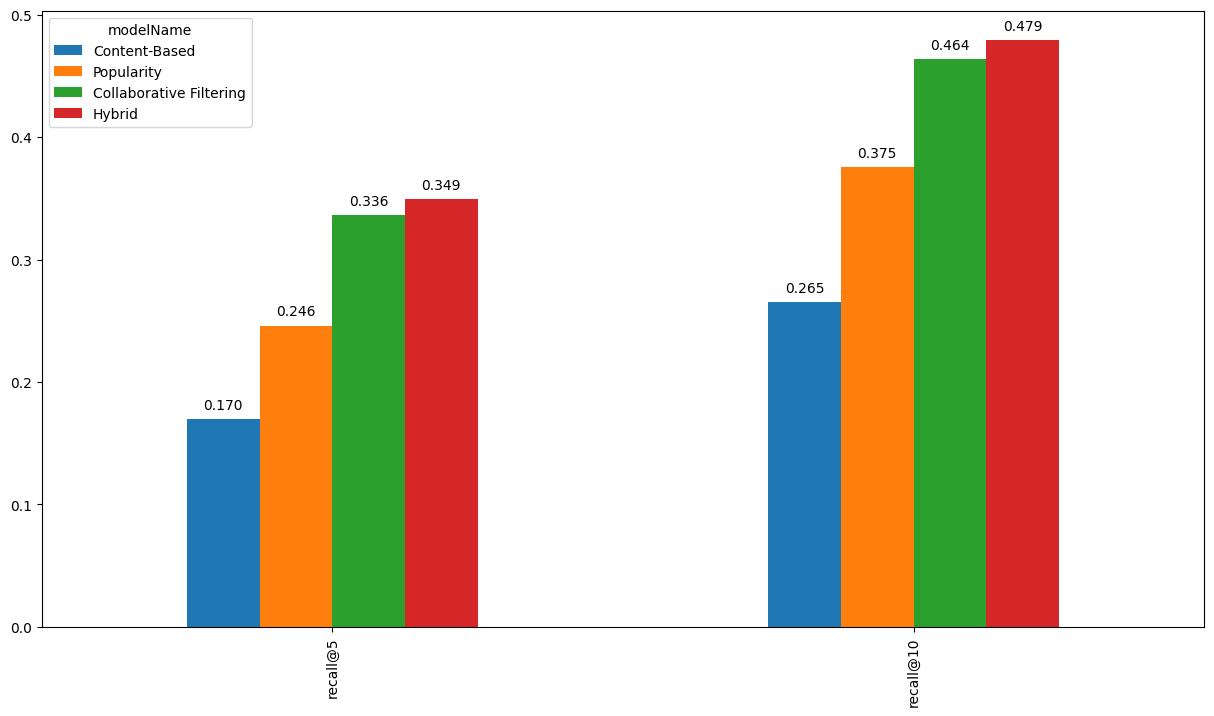

In [182]:

ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

* Testing

In [183]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(shared_articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('new_event_type', ascending = False)[['new_event_type', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [184]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,new_event_type,contentId,title,url,lang
112,4.000000,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
63,3.906891,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
5,3.807355,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
51,3.700440,-532999578436827210,IBM Seeks to Simplify Graph with New Titan Ser...,https://www.datanami.com/2016/07/27/ibm-seeks-...,en
116,3.459432,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
64,3.169925,444378495316508239,How to choose algorithms for Microsoft Azure M...,https://azure.microsoft.com/en-us/documentatio...,en
32,3.000000,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
62,3.000000,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
44,2.584963,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
105,2.584963,4430520614172753870,"Facebook, Amazon, Google, IBM and Microsoft co...",https://techcrunch.com/2016/09/28/facebook-ama...,en


In [185]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,37.833676,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
1,37.383734,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
2,36.145453,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
3,35.890305,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
4,35.739330,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
5,35.465985,-3269885695260066314,The Competitive Landscape for Machine Intellig...,https://hbr.org/2016/11/the-competitive-landsc...,en
6,35.341894,524776334673868069,Graph-powered Machine Learning at Google,https://research.googleblog.com/2016/10/graph-...,en
7,34.164770,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,34.047257,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
9,33.816661,-1901742495252324928,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en


In [186]:
import pickle
item_ids = pickle.dump( item_ids, open(r"C:\Projects\recommender-systems\Service\item_ids.p", "wb" ) )
user_profiles = pickle.dump( user_profiles, open(r"C:\Projects\recommender-systems\Service\user_profiles.p", "wb" ) )
tfidf_matrix = pickle.dump( tfidf_matrix, open(r"C:\Projects\recommender-systems\Service\tfidf_matrix.p", "wb" ) )
content_based_recommender_model = pickle.dump( content_based_recommender_model, open(r"C:\Projects\recommender-systems\Service\content_based_recommender_model.p", "wb" ) )